# Airline data (March to June, 2019)

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("D:/Project_DA/EDA_of_Airline_dataset/Dataset/airlines_data_csv.csv")

In [4]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
df.shape

(10683, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


## *Data Cleaning and Preprocessing*

In [7]:
#display the row , where total stop is nan, so that we can replace that nan value
df[df['Total_Stops'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


Missing value of "Route" and "Total stops" belongs to Air India Airline

In [8]:
df.Airline.unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

We have noticed each airline is subdivided into two different parts

In [9]:
#working with the copy of the original dataset
df_A = df.copy()

In [10]:
#We will combine the 'two-parts' airlines to make our categorical features more consistent with the rest of the variables
df_A['Airline'] = np.where(df_A['Airline'] == "Jet Airways Business", "Jet Airways", df_A['Airline'])
df_A['Airline'] = np.where(df_A['Airline'] == "Multiple carriers Premium economy", "Multiple carriers", df_A['Airline'])
df_A['Airline'] = np.where(df_A['Airline'] == "Vistara Premium economy", "Vistara", df_A['Airline'])

In [11]:
#converting "Total_stops" into a numeric column
df_A.Total_Stops.unique().tolist()

['non-stop', '2 stops', '1 stop', '3 stops', nan, '4 stops']

In [12]:
df_A.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

C:\Users\NAYANIKA\AppData\Local\Temp\ipykernel_47912\492365852.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_A.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)


In [13]:
df_A.groupby('Airline')['Total_Stops'].agg(pd.Series.mode).to_frame()

,Total_Stops
Airline,
Air Asia,0.0
Air India,2.0
GoAir,1.0
IndiGo,0.0
Jet Airways,1.0
Multiple carriers,1.0
SpiceJet,0.0
Trujet,1.0
Vistara,0.0


In [14]:
#replacing the nan value of Air india for "Total_stops" with the most frequent total stops
df_A['Total_Stops'].replace(np.nan , 2, inplace = True)

C:\Users\NAYANIKA\AppData\Local\Temp\ipykernel_47912\2687061901.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_A['Total_Stops'].replace(np.nan , 2, inplace = True)


#### Feature Transformation

In [15]:
#Converting 'Date_of_Journey', 'Dep_Time', and 'Arrival_Time' to datetime format
df_A['Date_of_Journey'] = pd.to_datetime(df_A['Date_of_Journey'], format = "%d/%m/%Y")


In [16]:
# Combining 'Date_of_Journey' with 'Dep_Time' (since Dep_Time is time-only)
df_A['Dep_Time'] =pd.to_datetime(df_A['Date_of_Journey'].astype(str) + ' ' + df_A['Dep_Time'])

In [17]:
df_A['Dep_Hour'] = df_A['Dep_Time'].dt.hour

In [18]:
# Function to handle mixed date and time formats in 'Arrival_Time'
def convert_arrival_time(arrival, journey_date):
    # Check if arrival contains a date (using regex)
    if re.search(r'\d{2} \w{3}', arrival):
        # If it contains a date, parse and set the correct year from 'Date_of_Journey'
        parsed_time = pd.to_datetime(arrival, format='%H:%M %d %b', errors='coerce')
        return parsed_time.replace(year=journey_date.year)  # Set the correct year from 'Date_of_Journey'
    else:
        # If it only contains time, combine it with the 'Date_of_Journey'
        return pd.to_datetime(journey_date.strftime('%Y-%m-%d') + ' ' + arrival, errors='coerce')

In [19]:
# Apply the function to convert 'Arrival_Time'
df_A['Arrival_Time'] = df_A.apply(lambda row: convert_arrival_time(row['Arrival_Time'], row['Date_of_Journey']), axis=1)

In [20]:
df_A['Arrival_Hour'] = df_A['Arrival_Time'].dt.hour

In [21]:
df_A['Duration_Day_Time'] = df_A['Arrival_Time'] - df_A['Dep_Time']

In [22]:
#taking only hour, minute and seconds from duration_day_time, and converting them datetime format for easier analysis
df_A['Duration_Time'] = pd.to_datetime(df_A['Duration_Day_Time'].apply(lambda x: f"{x.components.hours:02}:{x.components.minutes:02}:{x.components.seconds:02}"))

C:\Users\NAYANIKA\AppData\Local\Temp\ipykernel_47912\1103671046.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_A['Duration_Time'] = pd.to_datetime(df_A['Duration_Day_Time'].apply(lambda x: f"{x.components.hours:02}:{x.components.minutes:02}:{x.components.seconds:02}"))


In [23]:
df_A['Duration_HoursInMins']=(df_A['Duration_Time'].dt.hour)*60

In [24]:
df_A['Duration_TotalInMins'] = (df_A['Duration_Time'].dt.minute)+df_A['Duration_HoursInMins']

#### Splitting 'Departure/Arrival_Time' into Time Zones

In [25]:
df_A['Dep_timezone'] = pd.cut(df_A.Dep_Hour, [0,6,12,18,24], labels=['Night','Morning','Afternoon','Evening'])

In [26]:
df_A['Arrival_timezone'] = pd.cut(df_A.Arrival_Hour, [0,6,12,18,24], labels=['Night','Morning','Afternoon','Evening'])

#### Categorical Encoding

In [27]:
#One_hot_encoding
dummies = pd.get_dummies(df_A[['Airline', 'Source', 'Destination']], prefix=['Airline', 'Source', 'Destination'])

In [28]:
df_encoded = pd.concat([df_A, dummies], axis=1)

## *Exploratory Data Analysis*

### Univariate Analysis

#### Analysing the distribution of flights among different airlines from March 2019 to June 2019

In [29]:
Airline_counts = df_encoded['Airline'].value_counts()

C:\Users\NAYANIKA\AppData\Local\Temp\ipykernel_47912\932699961.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=Airline_counts.index, y=Airline_counts.values, palette="viridis")


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Jet Airways'),
  Text(1, 0, 'IndiGo'),
  Text(2, 0, 'Air India'),
  Text(3, 0, 'Multiple carriers'),
  Text(4, 0, 'SpiceJet'),
  Text(5, 0, 'Vistara'),
  Text(6, 0, 'Air Asia'),
  Text(7, 0, 'GoAir'),
  Text(8, 0, 'Trujet')])

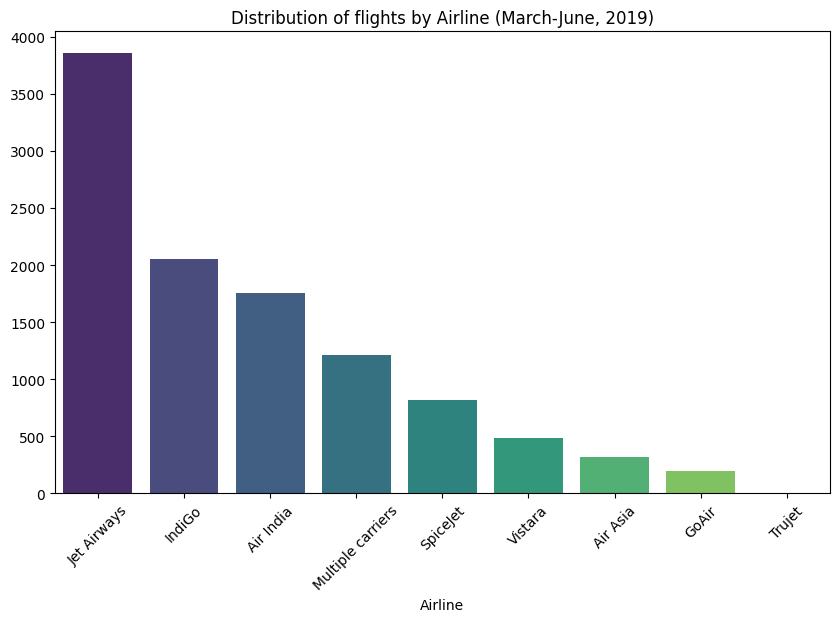

In [30]:
plt.figure(figsize=(10,6))
sns.barplot(x=Airline_counts.index, y=Airline_counts.values, palette="viridis")

plt.title("Distribution of flights by Airline (March-June, 2019)")
plt.xticks(rotation = 45)

### Bivariate Analysis

#### Price Distribution Analysis

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'IndiGo'),
  Text(1, 0, 'Air India'),
  Text(2, 0, 'Jet Airways'),
  Text(3, 0, 'SpiceJet'),
  Text(4, 0, 'Multiple carriers'),
  Text(5, 0, 'GoAir'),
  Text(6, 0, 'Vistara'),
  Text(7, 0, 'Air Asia'),
  Text(8, 0, 'Trujet')])

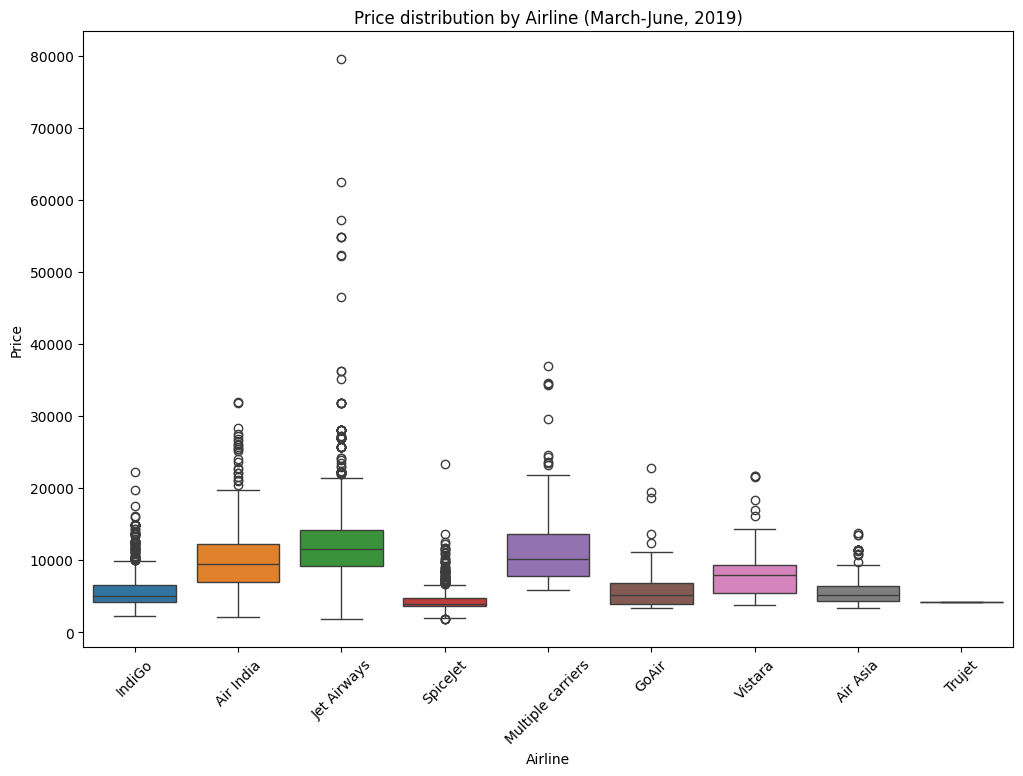

In [31]:
plt.figure(figsize=(12,8))
sns.boxplot(x= df_A['Airline'], y= df_A['Price'], hue= df_A['Airline'])
plt.title("Price distribution by Airline (March-June, 2019)")
plt.xticks(rotation= 45)

#### Outliers in the data likely represent business class or international flights with premium services.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'IndiGo'),
  Text(1, 0, 'Air India'),
  Text(2, 0, 'Jet Airways'),
  Text(3, 0, 'SpiceJet'),
  Text(4, 0, 'Multiple carriers'),
  Text(5, 0, 'GoAir'),
  Text(6, 0, 'Vistara'),
  Text(7, 0, 'Air Asia'),
  Text(8, 0, 'Vistara Premium economy'),
  Text(9, 0, 'Jet Airways Business'),
  Text(10, 0, 'Multiple carriers Premium economy'),
  Text(11, 0, 'Trujet')])

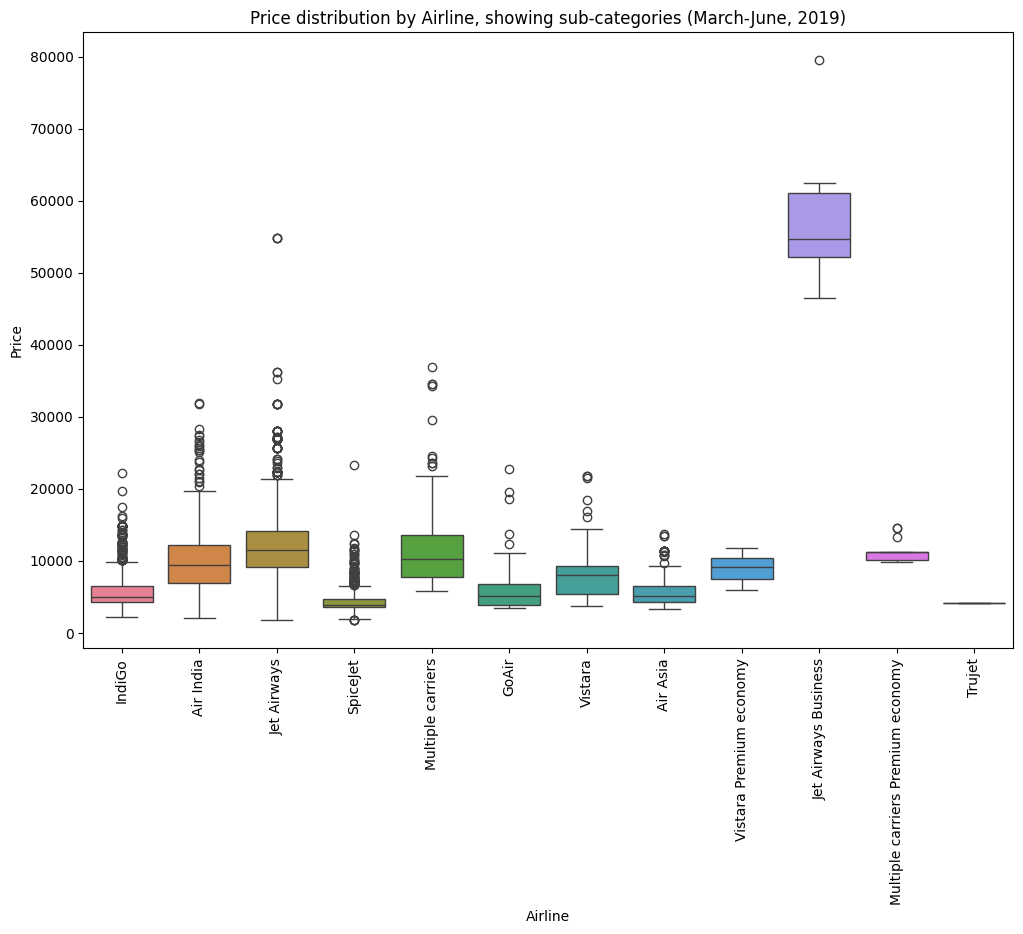

In [32]:
plt.figure(figsize=(12,8))
sns.boxplot(x= df['Airline'], y= df['Price'], hue= df['Airline'])
plt.title("Price distribution by Airline, showing sub-categories (March-June, 2019)")
plt.xticks(rotation= 90)

C:\Users\NAYANIKA\AppData\Local\Temp\ipykernel_47912\376231055.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data= df_A, x='Price', fill=True, color="blue", hue= 'Airline')


Text(0.5, 1.0, 'KDE Plot for Flight Price Density by Airline')

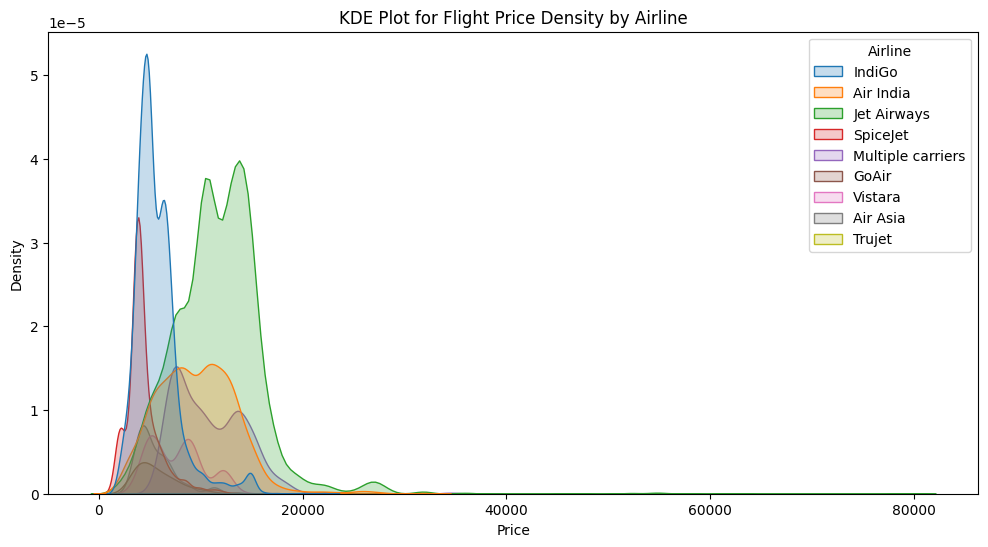

In [33]:
plt.figure(figsize= (12,6))
sns.kdeplot(data= df_A, x='Price', fill=True, color="blue", hue= 'Airline')
plt.title('KDE Plot for Flight Price Density by Airline')

#### Relationship between flight duration, Total stop and price

In [35]:
corr_price_duration = df_A[['Duration_TotalInMins', 'Price', 'Total_Stops']].corr()

In [36]:
corr_price_duration

,Duration_TotalInMins,Price,Total_Stops
Duration_TotalInMins,1.000000,0.450205,0.592532
Price,0.450205,1.000000,0.603751
Total_Stops,0.592532,0.603751,1.000000


In [37]:
df_pplt = df_A[['Duration_TotalInMins', 'Price', 'Total_Stops']]

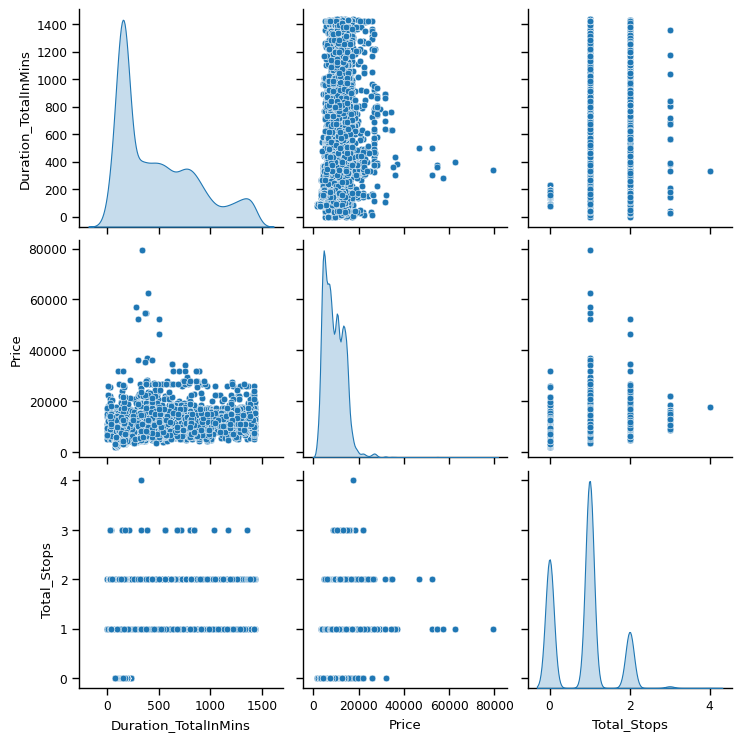

In [38]:
sns.set_context('paper')
sns.pairplot(df_pplt, diag_kind = 'kde')

#### The scatter of data points shows variability, likely due to factors such as seasonal discounts, airline-specific pricing strategies, or market competition for certain routes.

### Departure time Vs Price

C:\Users\NAYANIKA\AppData\Local\Temp\ipykernel_47912\1577819152.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data= df_A, x = "Dep_timezone", y="Price", palette = "Set2")


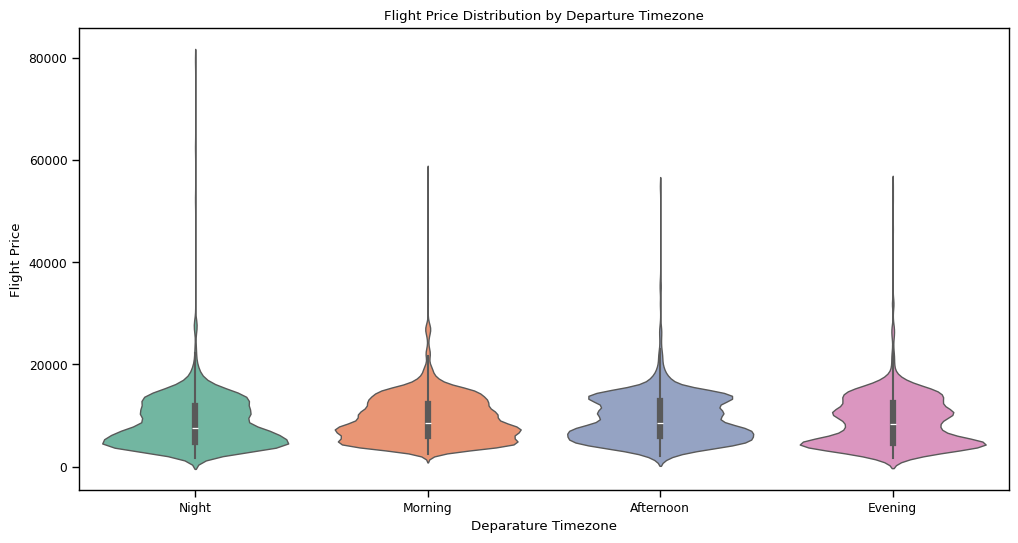

In [39]:
plt.figure(figsize=(12,6))
sns.violinplot(data= df_A, x = "Dep_timezone", y="Price", palette = "Set2")
plt.xlabel("Deparature Timezone")
plt.ylabel("Flight Price")
plt.title("Flight Price Distribution by Departure Timezone")
plt.show()

### Arrival time Vs Price

C:\Users\NAYANIKA\AppData\Local\Temp\ipykernel_47912\3308704538.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data= df_A, x = "Arrival_timezone", y="Price", palette = "Set2")


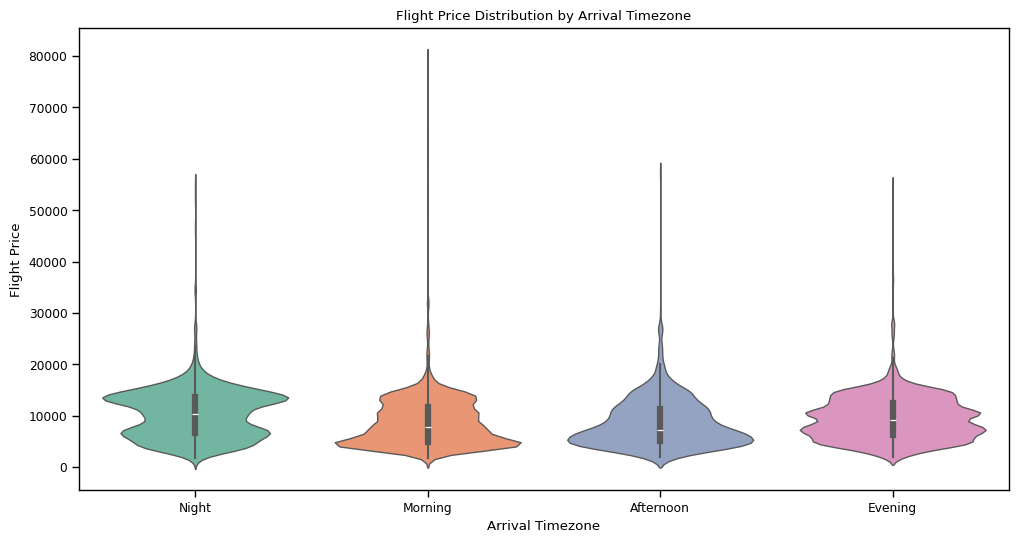

In [40]:
plt.figure(figsize=(12,6))
sns.violinplot(data= df_A, x = "Arrival_timezone", y="Price", palette = "Set2")
plt.xlabel("Arrival Timezone")
plt.ylabel("Flight Price")
plt.title("Flight Price Distribution by Arrival Timezone")
plt.show()

### Flight Price trend over Time

In [73]:
df_A['Journey_Month']= pd.to_datetime(df_A['Date_of_Journey']).dt.month_name()

In [72]:
df_A['Day_of_the_week'] = pd.to_datetime(df_A['Date_of_Journey']).dt.day_name()

Text(0.5, 1.0, 'Flight price trend over month for the year 2019')

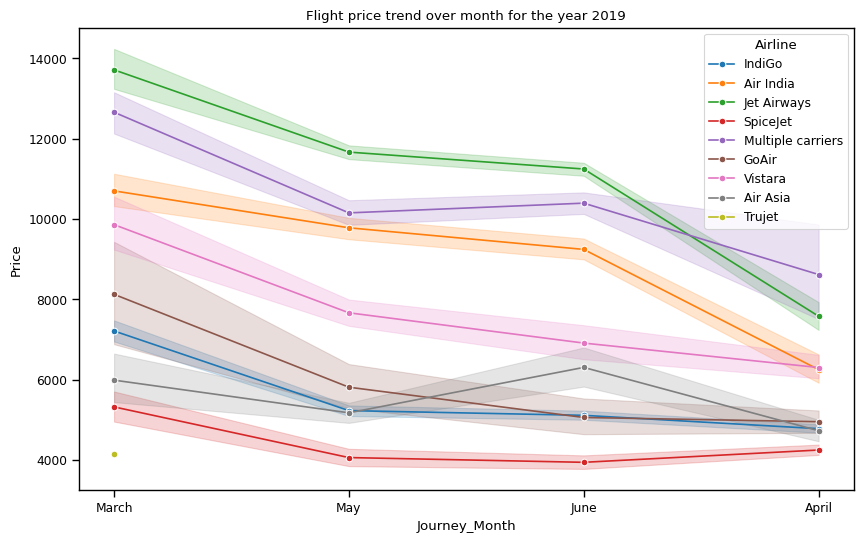

In [70]:
plt.figure(figsize= (10,6))
sns.lineplot(data = df_A, x= "Journey_Month", y = "Price", hue= "Airline", marker= "o")

plt.title("Flight price trend over month for the year 2019")

Text(0.5, 1.0, 'Flight price trend over day of the week for the year 2019')

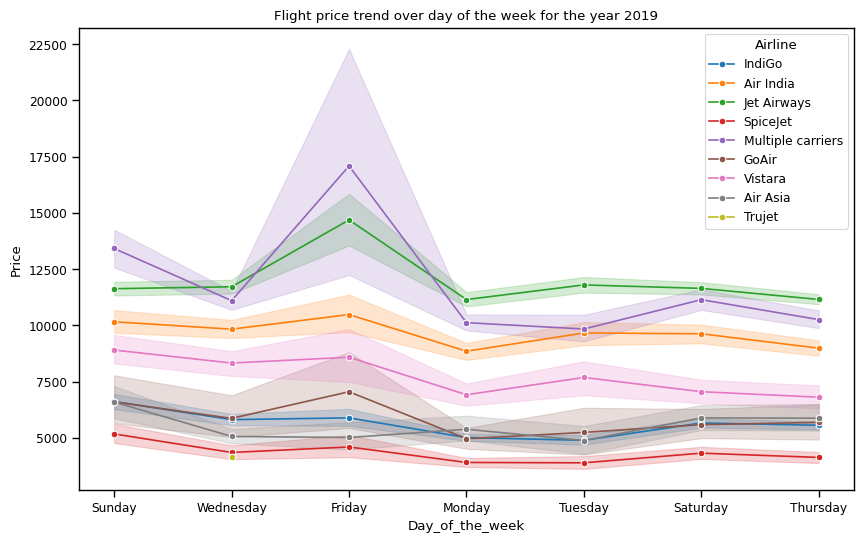

In [71]:
plt.figure(figsize= (10,6))
sns.lineplot(data = df_A, x= "Day_of_the_week", y = "Price", hue= "Airline", marker= "o")

plt.title("Flight price trend over day of the week for the year 2019")

### Multivariate Analysis

In [41]:
df_corr = df_A[['Price','Total_Stops', 'Dep_Hour','Arrival_Hour','Duration_TotalInMins']]

In [42]:
features = df_corr.corr()['Price'].sort_values()
features

Dep_Hour                0.006819
Arrival_Hour            0.024264
Duration_TotalInMins    0.450205
Total_Stops             0.603751
Price                   1.000000
Name: Price, dtype: float64

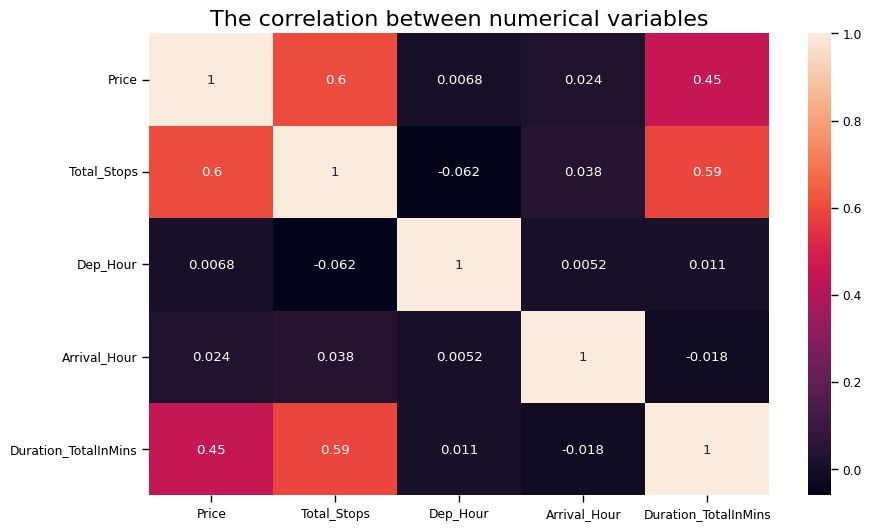

In [43]:
plt.figure(figsize=(10,6))
sns.heatmap(df_corr.corr(),annot=True)
plt.title('The correlation between numerical variables', fontsize = 16) 
plt.show()

### Feature Selection

In [45]:
df_corr_2 = df_encoded.loc[:,['Total_Stops', 'Airline_Air Asia',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Source_Banglore',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_New Delhi',
       'Duration_TotalInMins', 'Dep_Hour',
       'Arrival_Hour','Price']]

In [46]:
features_2 = df_corr_2.corr()['Price'].sort_values()
features_2

Airline_IndiGo              -0.361048
Destination_Delhi           -0.313401
Airline_SpiceJet            -0.296552
Source_Mumbai               -0.230745
Destination_Hyderabad       -0.230745
Destination_Kolkata         -0.179216
Source_Chennai              -0.179216
Airline_Air Asia            -0.133044
Source_Banglore             -0.118026
Airline_GoAir               -0.095146
Airline_Vistara             -0.060503
Airline_Trujet              -0.010380
Dep_Hour                     0.006819
Source_Kolkata               0.009377
Destination_Banglore         0.009377
Arrival_Hour                 0.024264
Airline_Air India            0.050346
Airline_Multiple carriers    0.141087
Destination_New Delhi        0.189785
Source_Delhi                 0.270619
Destination_Cochin           0.270619
Airline_Jet Airways          0.428490
Duration_TotalInMins         0.450205
Total_Stops                  0.603751
Price                        1.000000
Name: Price, dtype: float64

Text(0.5, 1.0, 'Correlation of all the features with PRICE')

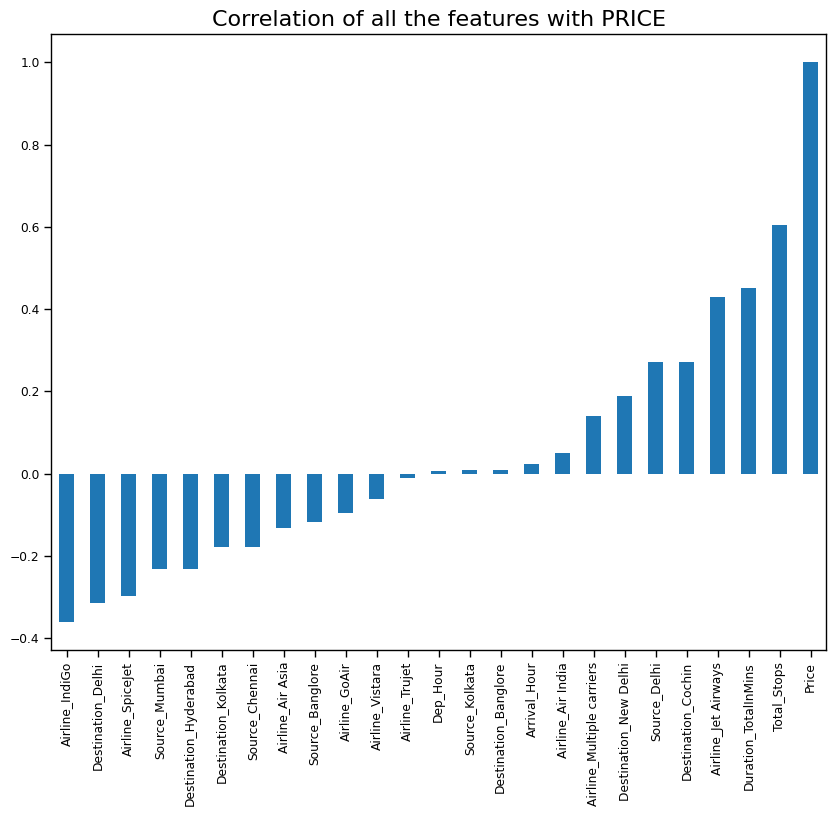

In [49]:
features_2.plot(kind='bar',figsize=(10,8))
plt.title("Correlation of all the features with PRICE", fontsize= 16)

***From the graph above, we can deduct some of the highly correlated features and select only those ones for any future analysis***

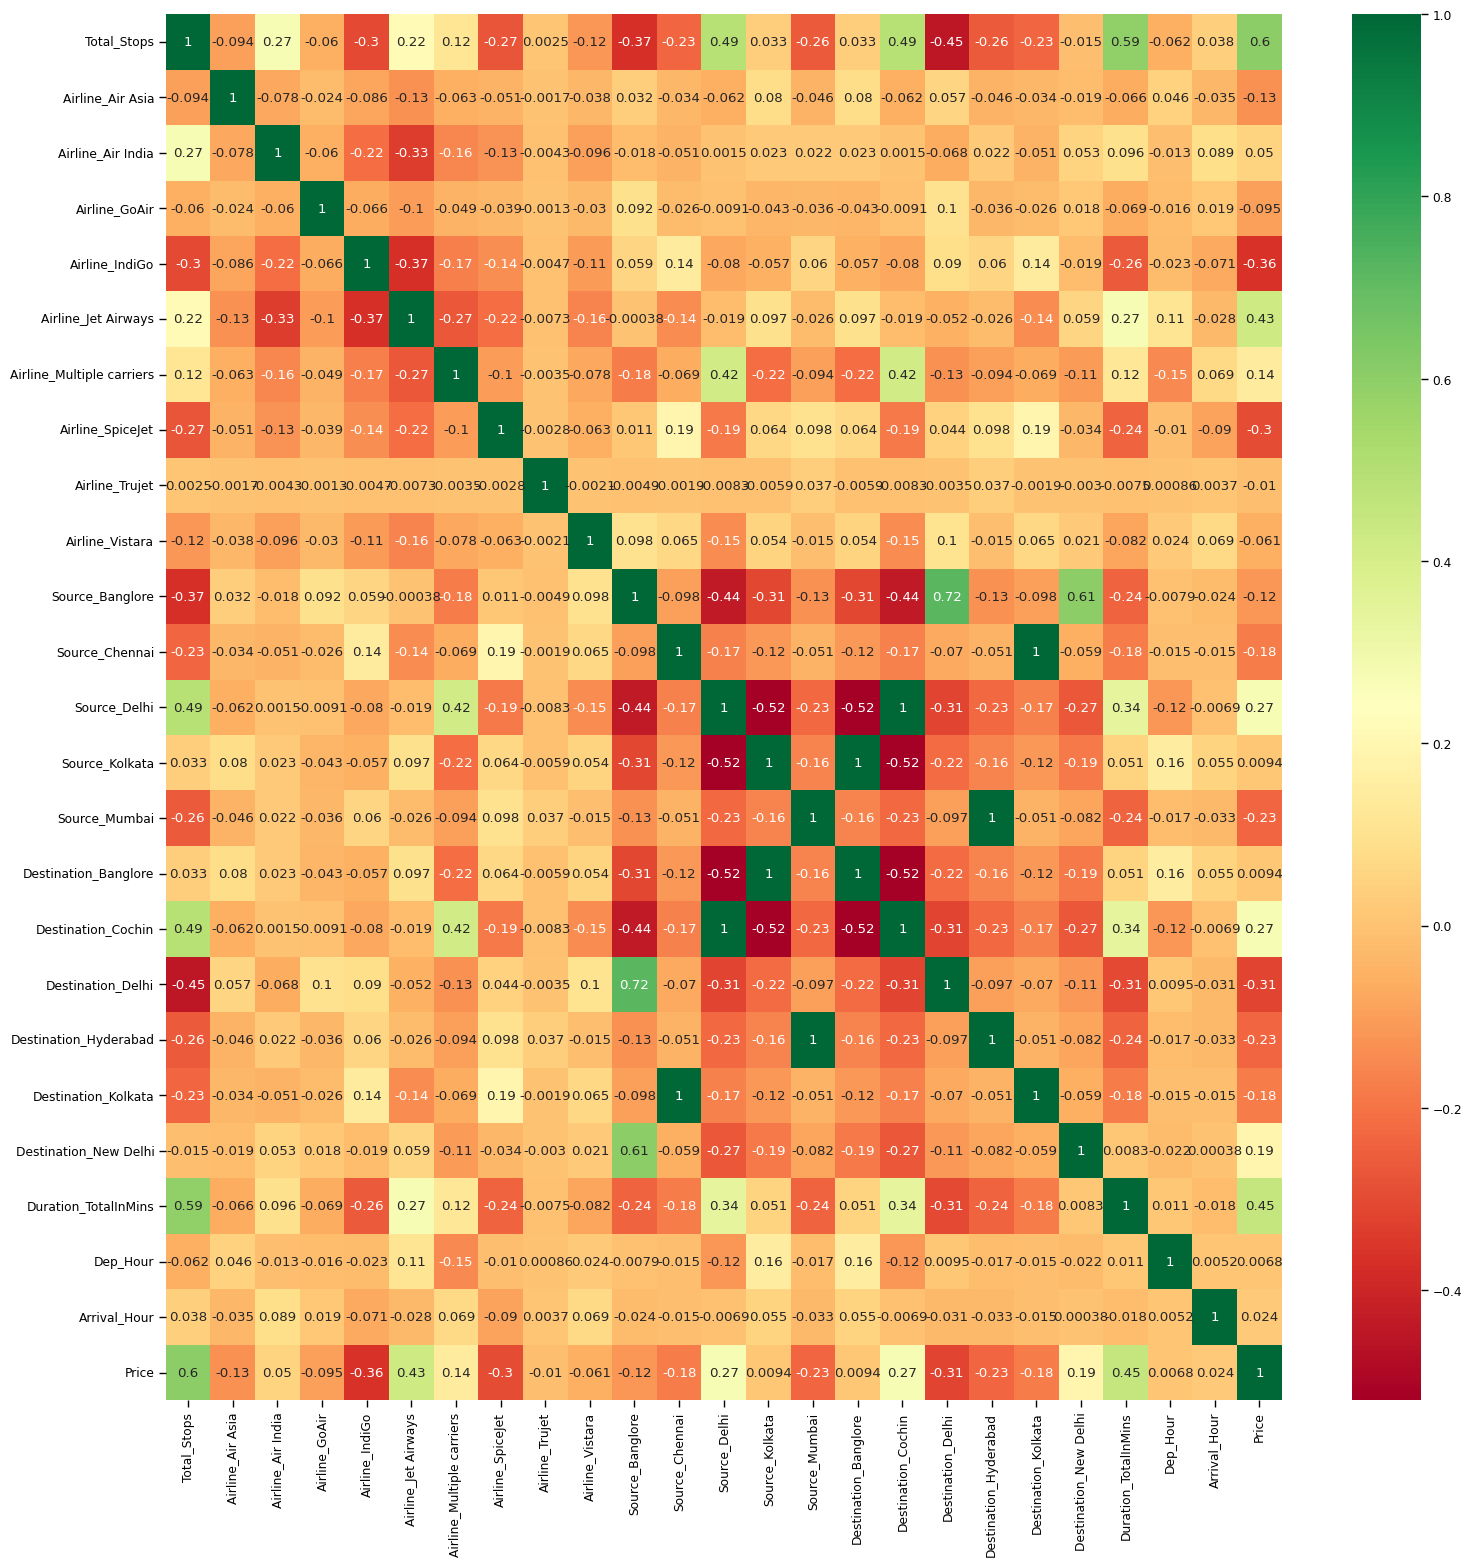

In [81]:
plt.figure(figsize=(18,18))
sns.heatmap(df_corr_2.corr(),annot=True,cmap='RdYlGn')

plt.show()